In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import the data "primaries.csv"

In [2]:
df = pd.read_csv('primaries.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 50 columns):
fips                   2450 non-null int64
county_name            2450 non-null object
state_postal           2450 non-null object
region                 2450 non-null object
election_date          2450 non-null object
racetype               2450 non-null object
tvotes                 2450 non-null int64
clinton                2450 non-null int64
obama                  2450 non-null int64
edwards                2450 non-null int64
margin                 2450 non-null float64
winner                 2430 non-null object
POP05_SQMI             2449 non-null float64
popUnder30_00          2449 non-null float64
pop65up_00             2449 non-null float64
presVote04             2449 non-null float64
kerry04                2449 non-null float64
Bush04                 2449 non-null float64
pres04margin           2449 non-null float64
pres04winner           2449 non-null object
pop06     

#### Primary

The data we are going to use is not from the criminal justice system.

It comes from the election in 2008, and specifically during the primaries. It was developed by Amanda Cox, a visual journalist at The New York Times. Here is her graphic:https://archive.nytimes.com/www.nytimes.com/imagepages/2008/04/16/us/20080416_OBAMA_GRAPHIC.html Have a look. The tree is like a game of 20 questions. If you want to know how a county will vote, answer a few questions. What is the racial makeup? What about the HS graduation rate? Where in the country is the county?

The questions are in the form of a tree -- as we have seen before, computer scientists grow their trees upside down. As you answer questions, you eventually end up at a leaf and a decision is made. Note that it's not perfect -- there is some uncertainty in the decision.

### Check how NY state has voted on the primaries

In [3]:
ny_vote = df[df.state_postal == 'NY'][['county_name', 'winner']]

### Calculate how many counties voted for Clinton & how many for Obama?

In [4]:
df.winner.value_counts()

clinton    1369
obama      1061
Name: winner, dtype: int64

### Now, given all the features in df, which ones "explain" county-level voting patterns? 

Hint: Consider whether or not a majority of the county voted for Bush in 2004

In [5]:
df.groupby([ 'pres04winner']).winner.value_counts()

pres04winner  winner 
bush          clinton    1178
              obama       760
kerry         obama       300
              clinton     191
Name: winner, dtype: int64

In [6]:
#Out of all the counties that voted for Kerry, how many voted for Obama
300/(300+191)

0.6109979633401222

In [7]:
# Out of all the counties that voted for Bush, how many voted for Clinton
1178/(1178+760)

0.6078431372549019

Therefore, Obama won about 61% of those counties not voting for Bush in 04, while Clinton won about 60% of those counties that did vote for Bush in 04. 

#### Now, consider the simple prediction rule: If a county voted for Bush in 04, we’ll say that they will vote for Clinton in the primary, while if a county was mostly in favor of Kerry in 04, we’ll assign the win to Obama.
Is it a good rule?

Of course this rule isn’t perfect; by applying it, we would make 191 + 760 = 951 mistakes (out of 2,430 counties, or about 39% error); we refer to these mistakes as having been "misclassified" by our simple rule. So the question becomes, can we do any better? What do you think?

### Use decision tree to predict who is going to win the election

1. Start by selecting all the necessary columns
2. Convert categorical data (the `region` column) to numeric values
3. Separate data into train and test
4. Build a decision tree
5. Fit the data

In [24]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

df.dropna(inplace=True)
X = df[['region','pres04margin', 'black06','hisp06','white06',
            'pct_less_30k','pct_more_100k','pct_hs_grad','pct_homeowner','POP05_SQMI']]
X = pd.get_dummies(X, drop_first=True)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, df.winner, test_size=0.3) # 70% training and 30% test

clf = tree.DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X_train, y_train)

#### Evaluate your model: calculate the accuracy ( the fraction of predictions our model got right)

In [22]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) 

Accuracy: 0.7012448132780082


In [23]:
metrics.confusion_matrix(y_test, y_pred)

array([[284, 112],
       [104, 223]])

#### Predict the winner in the county of your choice

In [10]:
clf.predict([[0.049557,527.0,2885.0,61063.0,0.3996,0.058778,0.8549,0.7277,38.7,0,0,1]])

array(['obama'], dtype=object)

### Plot the results
We're going to use graphviz to plot the results.
You can install it by running `!brew install graphviz`


In [11]:
from sklearn.tree import export_graphviz
# get column names
feature_names = list(X.columns)
#create a graphviz object
tree_dot = export_graphviz(clf, out_file=None, feature_names=feature_names)


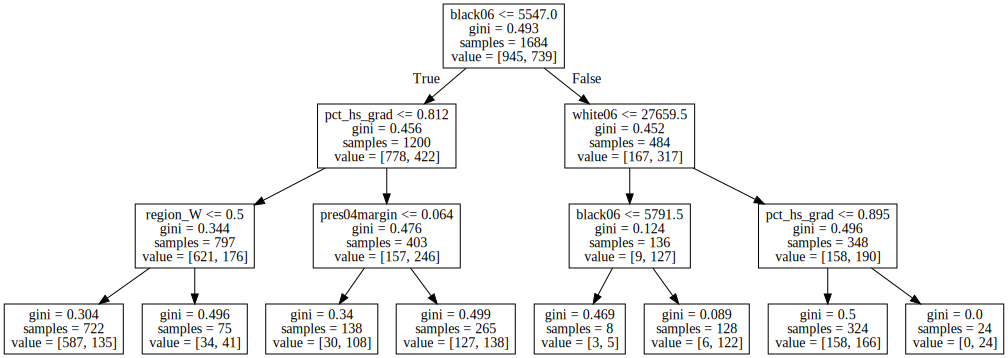

In [12]:
#!brew install graphviz
# vizualize the graphiz object
import graphviz
graphviz.Source(tree_dot)

### Create a Random Forest to predict the winner of the elections


In [13]:
from sklearn.ensemble import RandomForestClassifier
clf_forest=RandomForestClassifier(n_estimators=100, max_depth = 10)
clf_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Find the accuracy of the model

In [14]:
y_pred=clf_forest.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7952973720608575


#### Find out which features were the most important


In [15]:

feature_imp = pd.Series(clf_forest.feature_importances_,index=list(X_train.columns)).sort_values(ascending=False)
feature_imp

black06          0.196043
pct_hs_grad      0.135406
pres04margin     0.101981
pct_less_30k     0.101951
white06          0.091505
hisp06           0.086846
pct_more_100k    0.082061
POP05_SQMI       0.072466
pct_homeowner    0.069112
region_W         0.033223
region_S         0.016905
region_NE        0.012501
dtype: float64

#### Will the accuracy improve if remove the `region` field?

In [16]:
X = df[['pres04margin', 'black06','hisp06','white06',
            'pct_less_30k','pct_hs_grad','POP05_SQMI']]
X = pd.get_dummies(X,drop_first=True)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, df.winner, test_size=0.3) # 70% training and 30% test
clf_forest=RandomForestClassifier(n_estimators=100)
clf_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
y_pred=clf_forest.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7593360995850622


In [20]:
metrics.confusion_matrix(y_test, y_pred)

array([[313,  85],
       [ 89, 236]])